In [ ]:
#| hide
#| default_exp parallel
from nbdev import *
from fastcore.basics import patch

# Parallel calculations

> Prototype for parallel execution of calculators.

In [ ]:
from hecss import *
import hecss
from hecss.util import write_dfset, calc_init_xscale
from hecss.optimize import make_sampling

In [ ]:
from glob import glob
from tempfile import TemporaryDirectory
import os
import subprocess
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
from ase.calculators.vasp import Vasp
from ase import units as un
import ase
from tqdm.auto import tqdm
from scipy import stats
from ase.calculators import calculator
from ase.calculators.vasp.vasp import check_atoms

In [ ]:
import asyncio

async def run(cmd):
    proc = await asyncio.create_subprocess_shell(
        cmd,
        stdout=asyncio.subprocess.PIPE,
        stderr=asyncio.subprocess.PIPE)

    stdout, stderr = await proc.communicate()

    print(f'[{cmd!r} exited with {proc.returncode}]')
    if stdout:
        print(f'[stdout]\n{stdout.decode()}')
    if stderr:
        print(f'[stderr]\n{stderr.decode()}')

In [ ]:
@patch
async def _arun(self: Vasp, command=None, out=None, directory=None):
    """Method to explicitly execute VASP"""
    print(f'Parallel _run in {directory}')
    if command is None:
        command = self.command
    if directory is None:
        directory = self.directory
    # errorcode = subprocess.call(command,
    #                             shell=True,
    #                             stdout=out,
    #                             cwd=directory)
    # return errorcode
    proc = await asyncio.create_subprocess_shell(
        command,
        stdout=asyncio.subprocess.PIPE,
        stderr=asyncio.subprocess.PIPE)

    stdout, stderr = await proc.communicate()

    print(f'[{cmd!r} exited with {proc.returncode}]')
    if stdout:
        print(f'[stdout]\n{stdout.decode()}')
    if stderr:
        print(f'[stderr]\n{stderr.decode()}')    

In [ ]:
from ase.calculators import calculator
from ase.calculators.vasp.vasp import check_atoms

@patch
def calculate_par(self: Vasp,
                  atoms=None,
                  properties=('energy', ),
                  system_changes=tuple(calculator.all_changes)):
    """Do a VASP calculation in the specified directory.

    This will generate the necessary VASP input files, and then
    execute VASP. After execution, the energy, forces. etc. are read
    from the VASP output files.
    """
    print(f"Parallel calculate in {self.directory}")

    self.clear_results()

    if atoms is not None:
        self.atoms = atoms.copy()

    # Check for zero-length lattice vectors and PBC
    # and that we actually have an Atoms object.
    check_atoms(self.atoms)

    command = self.make_command(self.command)
    self.write_input(self.atoms, properties, system_changes)

    with self._txt_outstream() as out:
        errorcode =  self._run(command=command,
                              out=out,
                              directory=self.directory)

    if errorcode:
        raise calculator.CalculationFailed(
            '{} in {} returned an error: {:d}'.format(
                self.name, self.directory, errorcode))

    # Read results from calculation
    # self.update_atoms(atoms)
    # self.read_results()

In [ ]:
from time import sleep
from collections import deque

@patch 
def estimate_width_scale_par(self: HECSS, n=1, Tmax=600, set_scale=True, pbar=None):
    '''
    Estimate coefficient between temperature and displacement scale (eta).
    Calculate energy increase from the `n` temperatures uniformly 
    distributed between 0 and `Tmax` and calculate avarage $\sqrt{E-E0/T}$
    which is a width scale for a given temperature:
    $$
        w = \\eta\\sqrt{T}
    $$
    which comes from the assumed approximate relationship:
    $$
        \\frac{E(w(T))-E_0}{T} \\approx \\mathrm{const} = \\eta^2.
    $$
    
    #### Input
    * `n`    - number of sampling points
    * `Tmax` - max sampled temperature
    * `set_scale` - set scale parameter in the class after run
    * `pbar` - show progress bar during calculation
    
    #### Output
    * if wm_out :  mean(eta), std(eta), wm
    * else : mean(eta), std(eta)
    * wm - the nx3 array of: [width, Temperature, (E-E0)/nat]
    '''
    print('Parallel estimate_width_scale')
    if self.Ep0 is None:
        self.Ep0 = self.cryst.get_potential_energy()
    E0 = self.Ep0
    nat = len(self.cryst)
    dim = (nat, 3)    
    
    if self.directory is None :
        basedir = f'calc'
    else :
        basedir = self.directory
        
    cr = ase.Atoms(self.cryst.get_atomic_numbers(), 
                   cell=self.cryst.get_cell(),
                   scaled_positions=self.cryst.get_scaled_positions(),
                   pbc=True, 
                   calculator= self.calc() if callable(self.calc) 
                                           else self.calc)

    close_pbar = False
    
    if self.pbar and pbar is None:
        pbar = tqdm(total=n)
        close_pbar = True
    
    if pbar:
        pbar.reset(n)
        pbar.set_postfix_str('eta estimation')
        if self._eta_list:
            pbar.update(len(self._eta_list))

    structs = deque()
    while len(structs) < n - len(self._eta_list):
        T = stats.uniform.rvs(0, Tmax) # Kelvin
        if not T:
            continue
        w = self.w_scale * np.sqrt(T)
        dx = self.Q.rvs(size=dim, scale=w)
        cr.set_positions(self.cryst.get_positions()+dx)
        try :
            cr.calc.set(directory=f'{basedir}/w_est/{len(self._eta_list):03d}')
        except AttributeError :
            # Calculator is not directory-based
            # Ignore the error
            pass
        clc = cr.calc.__class__()
        clc.fromdict(cr.calc.asdict())
        clc.set(directory=f'{basedir}/w_est/{len(self._eta_list)+len(structs):03d}')
        clc.set(command=cr.calc.command)
        structs.append((T, w, dx, clc))
        
    for T, w, dx, clc in structs:
        clc.calculate(clc.atoms)

    print('Checking')
    done = []
    while len(self._eta_list) < n:
        sleep(5)
        while structs:
            T, w, dx, clc = structs.popleft()
            try :
                clc.read_results()
            except (calculator.ReadError, FileNotFoundError):
                structs.append((T, w, dx, clc))
                continue
            print(f'{clc.directory}')
            done.append((T, w, dx, clc))
            E = clc.get_potential_energy()
            i = len(self._eta_list)
            self._eta_samples.append((i, i, dx, clc.get_forces(), (E-E0)/nat))
            self._eta_list.append([w, T, (E-E0)/nat])

            if pbar:
                pbar.update()

    wm = np.array(self._eta_list).T
    y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
    m = y.mean()
    
    xscale = np.ones(dim)
    vir = np.array([abs(s[2]*s[3]) for s in self._eta_samples])
    vir /= vir.mean(axis=(-1,-2))[:,None,None]

    elems = self.cryst.get_chemical_symbols()
    for n, el in enumerate(set(elems)):
        elmask = np.array(elems)==el
        xscale[elmask] = 1/np.sqrt(vir[:, elmask, :].mean())
    
    if pbar and close_pbar:
        pbar.close()
    
    if set_scale:
        self.eta = m
        self.xscale_init = xscale
        
    return m, y.std(), xscale

In [ ]:
#|vasp
# Quick test using conventional unit cell
supercell = '2x2x2'
supercell = '1x1x1'

In [ ]:
#|vasp
# Directory in which our project resides
base_dir = f'example/VASP_3C-SiC/{supercell}/'
calc_dir = TemporaryDirectory(dir='TMP')

In [ ]:
#| vasp
# Read the structure (previously calculated unit(super) cell)
# The command argument is specific to the cluster setup
calc = Vasp(label='cryst', directory=f'{base_dir}/sc_{supercell}/', restart=True)

# This just makes a copy of atoms object
# Do not generate supercell here - your atom ordering will be wrong!
cryst = calc.atoms.repeat(1)

In [ ]:
#|vasp
print('Stress tensor: ', end='')
for ss in calc.get_stress()/un.GPa:
    print(f'{ss:.3f}', end=' ')
print('GPa')
Ep0 = calc.get_potential_energy()

Stress tensor: 0.017 0.017 0.017 0.000 0.000 0.000 GPa


In [ ]:
os.getcwd()

'/home/jochym/Projects/hecss/devel'

In [ ]:
#|vasp
# Setup the calculator - single point energy calculation
# The details will change here from case to case
# We are using run-vasp from the current directory!
calc.set(directory=f'{calc_dir.name}/sc')
calc.set(command=f'{os.getcwd()}/run-calc.sh "vasp_test"')
calc.set(nsw=0)
cryst.set_calculator(calc)

In [ ]:
#|vasp
# Prepare space for the results.
# We use defaultdict to automatically
# initialize the items to empty list.
samples = defaultdict(lambda : [])

# Space for amplitude correction data
xsl = []

In [ ]:
#|vasp
# Build the sampler
hecss = HECSS(cryst, calc, 
              directory=calc_dir.name,
              w_search = True,
              pbar=True,
              )

In [ ]:
#|vasp
hecss.Ep0 = Ep0

Parallel estimate_width_scale


  0%|          | 0/15 [00:00<?, ?it/s]

sbatch options: -W
Submitted batch job 232259
sbatch options: -W
Submitted batch job 232260
sbatch options: -W
Submitted batch job 232261
sbatch options: -W
Submitted batch job 232262
sbatch options: -W
Submitted batch job 232263
sbatch options: -W
Submitted batch job 232264
sbatch options: -W
Submitted batch job 232265
sbatch options: -W
Submitted batch job 232266
sbatch options: -W
Submitted batch job 232267
sbatch options: -W
Submitted batch job 232268
sbatch options: -W
Submitted batch job 232269
sbatch options: -W
Submitted batch job 232270
sbatch options: -W
Submitted batch job 232271
sbatch options: -W
Submitted batch job 232272
sbatch options: -W
Submitted batch job 232273
Checking
TMP/tmprm0840sw/w_est/000
TMP/tmprm0840sw/w_est/001
TMP/tmprm0840sw/w_est/002
TMP/tmprm0840sw/w_est/003
TMP/tmprm0840sw/w_est/004
TMP/tmprm0840sw/w_est/005
TMP/tmprm0840sw/w_est/006
TMP/tmprm0840sw/w_est/007
TMP/tmprm0840sw/w_est/008
TMP/tmprm0840sw/w_est/009
TMP/tmprm0840sw/w_est/010
TMP/tmprm0840sw

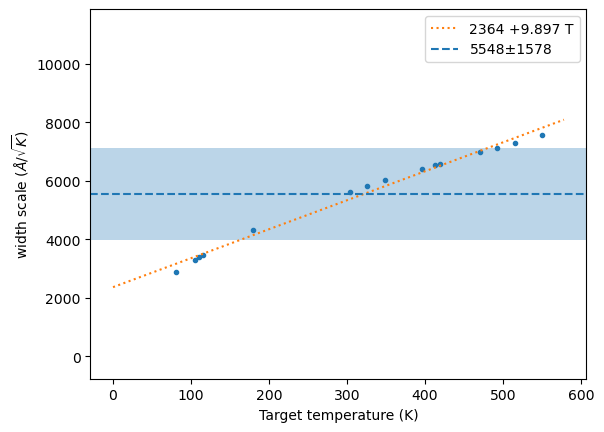

In [ ]:
#|vasp
N = 15
m, s, xscl = hecss.estimate_width_scale_par(N)
wm = np.array(hecss._eta_list).T
y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
plt.plot(wm[1], y, '.');
x = np.linspace(0, 1.05*wm[1].max(), 2)
fit = np.polyfit(wm[1], y, 1)
plt.plot(x, np.polyval(fit, x), ':', label=f'{fit[1]:.4g} {fit[0]:+.4g} T')
plt.axhline(m, ls='--', label=f'{m:.4g}±{s:.4g}')
plt.axhspan(m-s, m+s, alpha=0.3)
plt.ylim(m-4*s, m+4*s)
plt.xlabel('Target temperature (K)')
plt.ylabel('width scale ($\\AA/\\sqrt{K}$)')
plt.legend();

In [ ]:
#|hide
#|vasp
assert False
calc_dir.cleanup()

AssertionError: 

In [ ]:
#|vasp

await asyncio.gather(*[run(f'cd {d} && ../../../run-calc.sh') 
                      for d in sorted(glob('TMP/w_est/???'))])

In [ ]:
#|vasp

await asyncio.gather(run(f'cd TMP/w_est/000/ && ../../../run-calc.sh'))

In [ ]:
#|vasp

from ase.calculators.calculator import Calculator

In [ ]:
#|vasp

cc = Calculator()

cc.fromdict()

cc = calc.__class__()

cc.fromdict(calc.todict())

cc.atoms

calc.atoms

calc.todict()

calc.todict()

calc.asdict()

cc = calc.__class__()
cc.fromdict(calc.asdict())
cc.asdict()

cc.atoms